## This code executes every control step.

In [1]:
%matplotlib inline
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import math

We specify our prediction horizon $T$, and our control horizon, $M$.

The starting (current) blood glucose is stored in ```init_state```.

In [2]:
T = 100
M = 50
init_state = 250

These are the paramters relevant to the control model.

A is the matrix which defines open-loop blood glucose behavior:

$$
A = \begin{bmatrix}
p_1 + 2 p_2 & -2 p_1 p_2 - p_2^2 & p_1  p_2^2\\
1 & 0 & 0\\
0 & 1 & 0
\end{bmatrix}
$$
B is the matrix which defines the effect of the control input on the state.
$$
1800 \frac{g}{u_{TDI}} \times \begin{bmatrix} 1\\0\\0 \end{bmatrix}
$$

In [3]:
p1 = 0.98
p2 = 0.965
g = -90 * (1-p1)*(1-p2)*(1-p2)
u_TDI = 70
A = np.array([   
        [p1+2*p2, -2*p1*p2-p2*p2, p1*p2*p2],
        [1,0,0],
        [0,1,0]])
B = 1800 * g / u_TDI * np.array([[1],[0],[0]])

Here is where we set the problem up in CVXPY.

$x_k \forall k \in \mathbb{Z_T+1}$ is the set of sequential state vectors $x$ within the prediction horizon, $T+1$. One additional state is appended because it is dependent on all of the prior control actions.

$u_k \forall k \in \mathbb{Z_M}$ is the set of all sequential control inputs $u$ within the prediction horizon, $T$.

$x, u$ are stored in special ```Variables``` so that cvx can optimize them.

In [4]:
x = cp.Variable((3, T+1))
u = cp.Variable((1, T))

Then, we build costs and constraints. We will minimize the cost function:
$$
J(x,u) = (x-100)^2 + u^2
$$
This penalizes any readings away from 100, and any positive control inputs. Thus we get as close as possible to 100, using the least amount of insulin.

The constraints are as follows:

$$
x_{k+1} = A x_k + B u_k
$$
This is the model constraint; that, a future state $x_1$ is a linear combination of the prior state $x_0$ and the open-loop matrix $A$ plus the effect of the prior control input $u_0$. This is an affine constraint, because the model is linear.

Then, we have $u_0>0$, that is, no negative insulin can be dosed. We also make sure that the controller does not model doses past the control horizon, $M$.

Finally, we know that the first state must be the initial state, so we set it to our initial state. When the controller is in action, this will be given by the CGM.

In [5]:
cost = 0
constraints = []
for t in range(T):
    cost += cp.sum_squares(x[:,t] - 100) + cp.sum_squares(u[:,t])
    constraints += [
        x[:,t+1] == A @ x[:,t] + B @ u[:,t],
        u[:,t] >= 0,
        u[:,M:T] == 0]
constraints += [x[:,0] == init_state]

ValueError: Invalid dimensions (1, 0).

We form and solve the problem in cvx using the ```ECOS``` solver. We minimize the cost function we built above with the constraints.

In [6]:
problem = cp.Problem(cp.Minimize(cost), constraints)
problem.solve(verbose=True, solver='ECOS')


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -4.507e-01  +7e+00  8e-03  7e-02  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  -1.358e-01  -1.415e-01  +3e-01  3e-04  3e-03  5e-02  1e-01  0.9586  6e-03   1  1  1 |  0  0
 2  -1.484e-03  -1.497e-03  +4e-03  3e-06  3e-05  6e-04  2e-03  0.9885  1e-04   1  1  1 |  0  0
 3  -1.635e-05  -1.640e-05  +4e-05  3e-08  3e-07  7e-06  2e-05  0.9890  1e-04   1  1  1 |  0  0
 4  -1.809e-07  -1.811e-07  +4e-07  3e-10  4e-09  7e-08  2e-07  0.9890  1e-04   1  1  1 |  0  0
 5  -2.002e-09  -2.000e-09  +5e-09  4e-12  4e-11  8e-10  2e-09  0.9890  1e-04   1  1  1 |  0  0

OPTIMAL (within feastol=4.0e-11, reltol=2.5e+00, abstol=4.9e-09).
Runtime: 0.001671 seconds.



-2.001815131243416e-09

We can see the values of $u$:

In [7]:
print(u.value[0,0])

0.0


Finally, we can generate a chart of our control action and what the controller predicts.

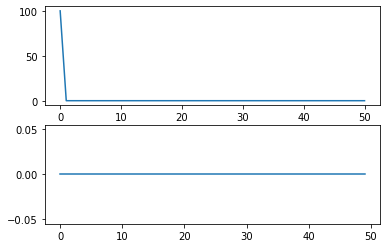

In [8]:
fig = plt.figure()
ax = fig.add_subplot(211)
plt.plot(x[0,:].value, label='state')
plt.subplot(2,1,2)
plt.plot(u[0,:].value, label='control')
plt.show()